In [10]:
%load_ext autoreload
%autoreload 2

from spelke_net.predictor.flow_predictor import LRASFlowPredictor
import h5py as h5
from spelke_net.utils.camera import pose_list_to_matrix
import matplotlib.pyplot as plt
import numpy as np
from spelke_net.utils.segment import offset_multiple_centroids
from spelke_net.utils.segment import compute_avg_flow_from_logits,\
plot_expected_displacement_map, plot_image_with_virtual_poke, threshold_heatmap, plot_segment_overlay, sample_from_heatmap
import torch
from spelke_net.utils.flow import flow_to_image


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 📦 Load SpelkeNet Model 

In [11]:
model_name = 'SpelkeNet7B.pt'
device = 'cuda:4'

predictor = LRASFlowPredictor(
        model_name, 'rgb_quantizer.pt', 'flow_quantizer.pt', device=device
    )

Loading model from /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out/SpelkeNet7B.pt
|-------------------------------------------------|
|         ✨ Model Information Overview ✨        |
|-------------------------------------------------|
| 📦 Model Name:                                  |
| SpelkeNet7B.pt                                  |
|-------------------------------------------------|
| 📂 Model loaded from:                           |
| /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out |
|-------------------------------------------------|
| 🔢 7357.1M parameters in the model              |
|-------------------------------------------------|
Loading model from /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out/rgb_quantizer.pt
|-------------------------------------------------|
|         ✨ Model Information Overview ✨        |
|-------------------------------------------------|
| 📦 Model Name:                                  |
| rgb_quantizer.pt                                |
|---------

## 🖼️ Load Input Image ##

Text(0.5, 1.0, 'Input image')

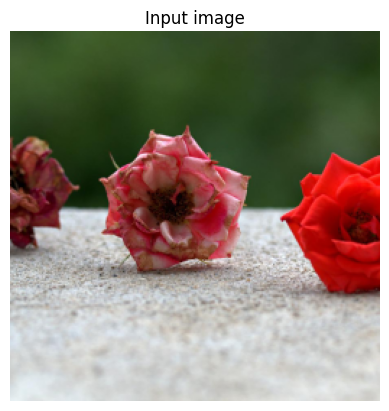

In [12]:
img = plt.imread('../demo_images/rose.png')[:, :, :3]
plt.imshow(img)
plt.axis('off')
plt.title('Input image')

## 🧭 Get Motion Affordance

#### Run a forward pass through SpelkeNet keeping the camera fixed

In [13]:
#set camera motion to zero: we want to understand the what parts of the scene will move upon external forces, independent of camera motion
campose = pose_list_to_matrix([0.0]*6)

#set the motion of the four corner to 0 to further refinforce a fixed camera
flow_cond = [[248,0,248,0],[0,0,0,0],[0,248,0,248],[248,248,248,248]]

#get prediction in parallel mode
preds = predictor.quantized_flow_prediction(
    img, campose=campose, flow_cond=flow_cond,
    num_seq_patches=0, mode="seq2par", seed=0,
)

#prob motion/motion affordance map
prob_map = 1 - preds["prob_no_motion"].cpu().numpy()

/ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/spelke_net/predictor/flow_predictor.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x: torch.tensor(x).permute(2,0,1) if len(x.shape) == 3 else torch.tensor(x).permute(0,3,1,2)),


#### Visualize Affordance Map

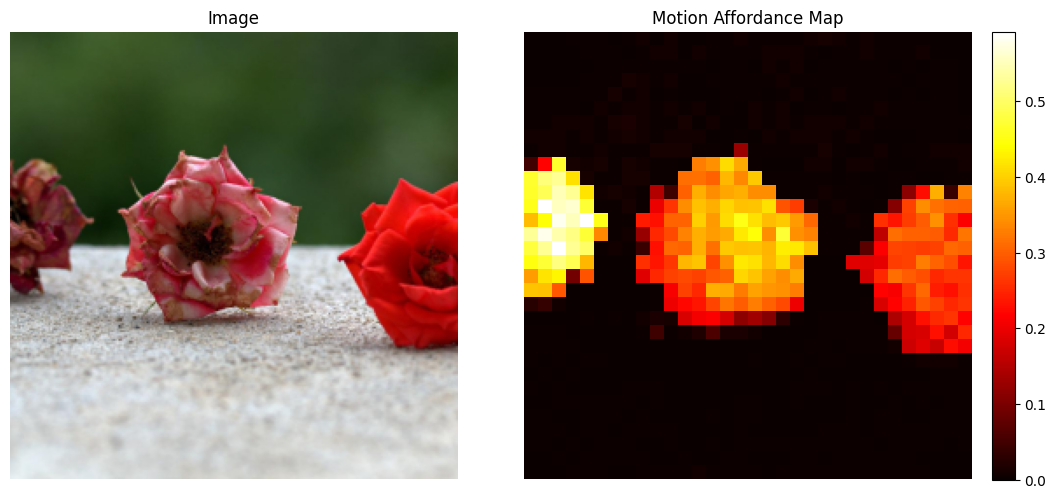

In [14]:
# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Show the original image
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Image")

# Show the probability of motion map
hm2 = axes[1].imshow(prob_map, cmap='hot')
axes[1].axis('off')
axes[1].set_title("Motion Affordance Map")

# Add colorbar for the heatmap
cbar2 = plt.colorbar(hm2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 🎲 Sample a candidate poke from the motion affordance map

#### Apply erosion to bias sampling closer to an object's internal region

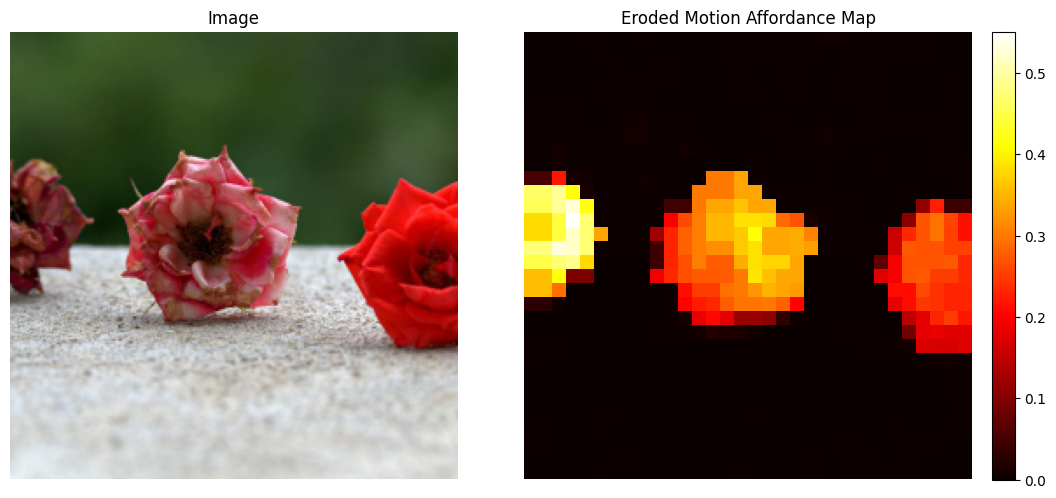

In [18]:
import numpy as np
from scipy.ndimage import minimum_filter

# Apply minimum filter with a 5x5 window
filtered_map = minimum_filter(prob_map, size=2)

import matplotlib.pyplot as plt

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Show the original image
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Image")

# Show the probability of motion map
hm2 = axes[1].imshow(filtered_map, cmap='hot')
axes[1].axis('off')
axes[1].set_title("Eroded Motion Affordance Map")

# Add colorbar for the heatmap
cbar2 = plt.colorbar(hm2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

#### Sample and Visualize

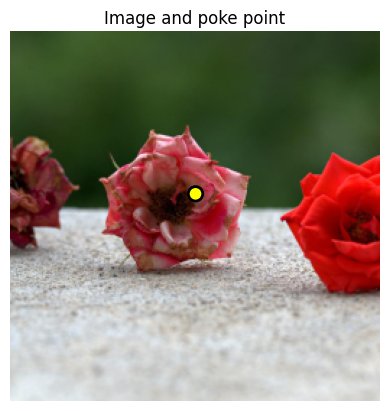

In [25]:
np.random.seed(42)

y, x = sample_from_heatmap(filtered_map)

#convert from 32x32 to 256x256 resolution
y = y*8
x = x*8

#visualize
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

# Add circle at (col, row) — note: imshow uses (x=col, y=row)
circle = plt.Circle((x, y), radius=5, facecolor='yellow', edgecolor='black', linewidth=2)
ax.add_patch(circle)

ax.set_title('Image and poke point')

plt.show()

## 🎲 🤏 Statistical Counterfactual Probing

#### Apply multiple virtual pokes at the sampled poke point and extract displacement maps

In [26]:
num_dirs = 8
min_mag = 10
max_mag = 15

#load the mapping between the flow token and flows using the flow token epigraphy procedure described in Sec 3.2 
token_to_flow_mapping = predictor.token_to_flow_dict 

probe_point = torch.tensor([x, y])

dx, dy = offset_multiple_centroids(probe_point, num_dirs, min_mag=min_mag, max_mag=max_mag) 

all_poke_vectors = []

all_expected_displacement_maps = []

x = probe_point[0].item() # N,
y = probe_point[1].item()

for ct in range(num_dirs):

    x_new = (x + dx[ct]).int().item()
    y_new = (y + dy[ct]).int().item()
    virtual_poke = [[x, y, x_new, y_new]]

    combined_flow = flow_cond + virtual_poke

    all_poke_vectors.append(np.array([x_new, y_new]))
    
    #get prediction in parallel mode
    predictions = predictor.quantized_flow_prediction(
            img,
            campose=campose,
            flow_cond=combined_flow,
            num_seq_patches=0,
            mode="seq2par", 
            seed=0, 
            mask_out=True,
        )

    #get expected direction of motion in parallel
    #range of flow tokens in the unified vocabulary
    start, end = predictor.model.config.flow_range
    
    logits = predictions["flow_logits"]
    
    parallel_flow_pred, flow_img = compute_avg_flow_from_logits(logits, start, end,
                                                                token_to_flow_dict=token_to_flow_mapping)

    all_expected_displacement_maps.append(parallel_flow_pred)

#### Compute motion correlation between input poke vector and predicted displacement maps

In [29]:
# First, compute all dot product maps and collect global min and max

def get_dot_product_map(avg_flow, flow_vector):

    # Compute dot product between avg_flow and direction vector
    dot_prod = torch.sum(
        avg_flow * torch.tensor(flow_vector, dtype=avg_flow.dtype, device=avg_flow.device)[None, None, :], dim=-1)
    # dot_prod_np = #dot_prod.cpu().numpy()

    return dot_prod
    
dot_maps = []
dot_min, dot_max = float('inf'), float('-inf')

for i in range(num_dirs):
    vect = all_poke_vectors[i] - np.array([x, y])
    dot_map = get_dot_product_map(all_expected_displacement_maps[i], vect)
    dot_map_np = dot_map.cpu().numpy()
    dot_maps.append(dot_map_np)

    dot_min = min(dot_min, dot_map_np.min())
    dot_max = max(dot_max, dot_map_np.max())


#### Visualize motion correlation maps

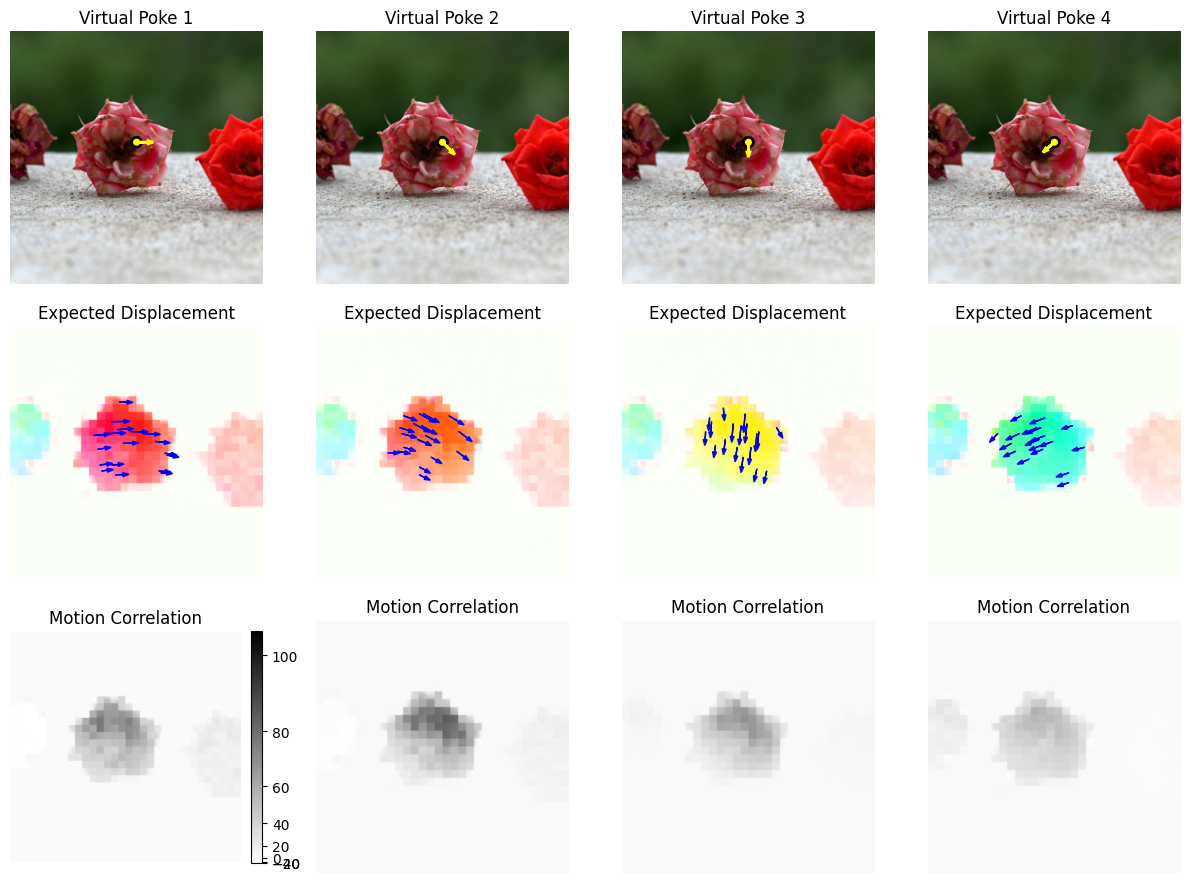

In [30]:
from matplotlib.colors import PowerNorm

num_examples = 4
fig, axes = plt.subplots(3, num_examples, figsize=(3 * num_examples, 9))

for i in range(num_examples):
    flow_cond_poke = [x, y, all_poke_vectors[i][0], all_poke_vectors[i][1]]
    expected_displacement = all_expected_displacement_maps[i]

    # Top row: input image + poke
    axes[0, i] = plot_image_with_virtual_poke(axes[0, i], img, flow_cond_poke)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Virtual Poke {i+1}")

    # Middle row: flow image and overlay
    flow_img = flow_to_image(expected_displacement.cpu().numpy())
    axes[1, i].imshow(flow_img)
    axes[1, i] = plot_expected_displacement_map(axes[1, i], expected_displacement)
    axes[1, i].axis('off')
    axes[1, i].set_title("Expected Displacement")

    gamma = 3.0 
    norm = PowerNorm(gamma=gamma, vmin=dot_min, vmax=dot_max)

    # Bottom row: dot product map with consistent range
    im = axes[2, i].imshow(dot_maps[i], cmap='gray_r', norm=norm)
    axes[2, i].axis('off')
    axes[2, i].set_title("Motion Correlation")
    if i == 0:
        cbar = plt.colorbar(im, ax=axes[2, i], fraction=0.046, pad=0.04)
    # cbar.set_label("", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Get expected motion correlation to discover Spelke objects

In [31]:
dot_bar = np.mean(np.stack(dot_maps, 0), 0)

#### Visualize extracted Spelke segment

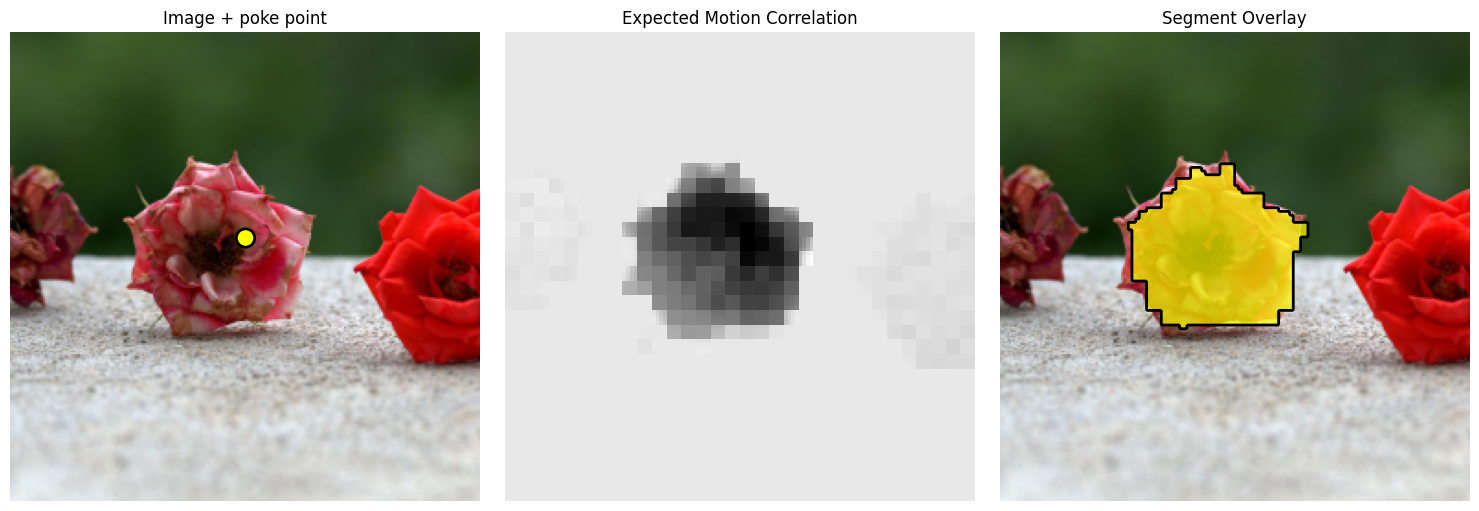

In [32]:
from skimage.transform import resize

segment = threshold_heatmap(dot_bar)  # binary mask (H_seg, W_seg)

segment_resized = resize(segment, (img.shape[0], img.shape[1]), order=0, preserve_range=True).astype(bool)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# -- Original image --
axes[0].imshow(img)
# Add circle at (col, row) — note: imshow uses (x=col, y=row)
circle = plt.Circle((x, y), radius=5, facecolor='yellow', edgecolor='black', linewidth=2)
axes[0].add_patch(circle)
axes[0].axis('off')
axes[0].set_title("Image + poke point")

# -- Average dot product map --
axes[1].imshow(dot_bar, cmap='gray_r')
axes[1].axis('off')
axes[1].set_title("Expected Motion Correlation")

axes[2].imshow(img)
axes[2] = plot_segment_overlay(axes[2], img, segment_resized)
axes[2].axis('off')
axes[2].set_title("Segment Overlay")

plt.tight_layout()
plt.show()